# Modeling the energy production and consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense, Input

import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

2024-01-22 14:13:53.208357: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 14:13:53.254434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 14:13:53.254463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 14:13:53.255779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 14:13:53.262713: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 14:13:53.262981: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
DATA_FILE_PATH = 'solar_energy_data_clean.csv'
df = pd.read_csv(DATA_FILE_PATH)

In [4]:
df

,datetime,target,eic_count,installed_capacity,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,...,cos_dayofyear,sin_hour,cos_hour,target_1d_lag,target_2d_lag,target_3d_lag,target_4d_lag,target_5d_lag,target_6d_lag,target_7d_lag
0,2021-09-08 00:00:00,0.000,6.0,324.2,14.586145,12.467920,0.000000,0.057953,0.150330,0.185695,...,-0.392574,0.00,1.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2021-09-08 01:00:00,0.000,6.0,324.2,14.404932,12.962000,0.007896,0.062828,0.022690,0.084471,...,-0.392574,0.26,0.97,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2021-09-08 02:00:00,0.000,6.0,324.2,14.233301,13.118494,0.392868,0.067619,0.003510,0.425801,...,-0.392574,0.50,0.87,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2021-09-08 03:00:00,0.000,6.0,324.2,14.188745,13.118677,0.357033,0.124176,0.000031,0.415109,...,-0.392574,0.71,0.71,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2021-09-08 04:00:00,0.000,6.0,324.2,14.884485,13.389856,0.370682,0.186813,0.308960,0.584599,...,-0.392574,0.87,0.50,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,2023-05-30 07:00:00,7.801,17.0,540.0,13.211206,4.093774,0.000000,0.090347,0.068436,0.129608,...,-0.843776,0.97,-0.26,14.188,30.298,24.865,5.508,10.203,13.126,10.318
15098,2023-05-30 08:00:00,18.419,17.0,540.0,13.226221,4.368066,0.000000,0.129105,0.043564,0.156006,...,-0.843776,0.87,-0.50,16.497,67.023,63.957,14.828,5.390,23.048,25.599
15099,2023-05-30 09:00:00,20.297,17.0,540.0,13.592676,4.190698,0.000000,0.187180,0.008461,0.193344,...,-0.843776,0.71,-0.71,26.215,119.496,108.454,35.562,9.823,38.745,37.534
15100,2023-05-30 10:00:00,41.602,17.0,540.0,13.897852,4.148706,0.000000,0.073303,0.000717,0.073761,...,-0.843776,0.50,-0.87,77.667,156.330,151.896,74.694,9.482,74.422,70.567


In [5]:
list(df.columns)

['datetime',
 'target',
 'eic_count',
 'installed_capacity',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation',
 'temperature_hist_1h',
 'dewpoint_hist_1h',
 'rain_hist_1h',
 'snowfall_hist_1h',
 'surface_pressure_hist_1h',
 'cloudcover_total_hist_1h',
 'cloudcover_low_hist_1h',
 'cloudcover_mid_hist_1h',
 'cloudcover_high_hist_1h',
 'windspeed_10m_hist_1h',
 'winddirection_10m_hist_1h',
 'shortwave_radiation_hist_1h',
 'direct_solar_radiation_hist_1h',
 'diffuse_radiation_hist_1h',
 'year',
 'month',
 'day',
 'weekday',
 'dayofyear',
 'hour',
 'sin_dayofyear',
 'cos_dayofyear',
 'sin_hour',
 'cos_hour',
 'target_1d_lag',
 'target_2d_lag',
 'target_3d_lag',
 'target_4d_lag',
 'target_5d_lag',
 'target_6d_lag',
 'target_7d_lag']

In [6]:
target = 'target'

In [7]:
features = [
    # solar panels characteristics
    'eic_count',
    'installed_capacity',
    
    # weather forecast
    'temperature',
    'dewpoint',
    'cloudcover_high',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_total',
    '10_metre_u_wind_component',
    '10_metre_v_wind_component',
    'direct_solar_radiation',
    'surface_solar_radiation_downwards',
    'snowfall',
    'total_precipitation',
    
    # historical weather
    'temperature_hist_1h',
    'dewpoint_hist_1h',
    'rain_hist_1h',
    'snowfall_hist_1h',
    'surface_pressure_hist_1h',
    'cloudcover_total_hist_1h',
    'cloudcover_low_hist_1h',
    'cloudcover_mid_hist_1h',
    'cloudcover_high_hist_1h',
    'windspeed_10m_hist_1h',
    'winddirection_10m_hist_1h',
    'shortwave_radiation_hist_1h',
    'direct_solar_radiation_hist_1h',
    'diffuse_radiation_hist_1h',
    
    # date and time
    'year',
    'month',
    'day',
    'dayofyear',
    'hour',
    'weekday',
    'sin_dayofyear',
    'cos_dayofyear',
    'sin_hour',
    'cos_hour',
    
    # lags of energy production
    'target_1d_lag',
    'target_2d_lag',
    'target_3d_lag',
    'target_4d_lag',
    'target_5d_lag',
    'target_6d_lag',
    'target_7d_lag'
]

### Train, validation and test set split

In [8]:
def split__train_val_test_sets(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
    
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.target.values
    y_val = df_val.target.values
    y_test = df_test.target.values
    
    del df_train['target']
    del df_val['target']
    del df_test['target']
    return df_train, df_test, df_val, y_train, y_test, y_val

In [9]:
df_train, df_test, df_val, y_train, y_test, y_val = split__train_val_test_sets(df)

In [10]:
df_train

,datetime,eic_count,installed_capacity,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,...,cos_dayofyear,sin_hour,cos_hour,target_1d_lag,target_2d_lag,target_3d_lag,target_4d_lag,target_5d_lag,target_6d_lag,target_7d_lag
0,2021-12-24 13:00:00,6.0,324.2,-8.628515,-12.491430,0.000000,0.126846,0.161148,0.202972,1.243114,...,0.990584,-0.26,-0.97,0.000,0.319,2.024,2.981,1.981,0.029,5.083
1,2022-12-31 11:00:00,18.0,645.2,6.019861,5.162744,1.000000,1.000000,0.996994,1.000000,3.689751,...,0.999853,0.26,-0.97,0.789,0.121,2.354,1.068,0.183,0.783,2.267
2,2021-10-11 04:00:00,6.0,324.2,8.033838,5.705957,0.023590,0.332062,0.051453,0.372131,0.964745,...,0.162366,0.87,0.50,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2023-01-26 01:00:00,21.0,771.2,2.760827,2.211084,0.000000,1.000000,0.839307,1.000000,4.249912,...,0.902030,0.26,0.97,0.004,0.000,0.003,0.002,0.000,0.000,0.004
4,2023-01-05 01:00:00,21.0,771.2,-4.889990,-8.085424,0.999993,0.004623,0.997772,0.999999,-6.944162,...,0.996318,0.26,0.97,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055,2023-01-30 17:00:00,21.0,771.2,1.595239,-0.993842,0.559677,0.285339,0.493240,0.751395,5.707976,...,0.870285,-0.97,-0.26,0.006,0.003,0.003,0.005,0.005,0.004,0.000
9056,2022-12-15 13:00:00,18.0,645.2,-2.995703,-3.821143,0.000000,0.595962,0.231705,0.757225,1.400368,...,0.957716,-0.26,-0.97,0.002,0.002,0.001,0.000,0.001,0.004,0.003
9057,2022-11-19 02:00:00,18.0,645.2,-3.712134,-8.252417,0.531586,0.982651,1.000000,0.999998,-4.355527,...,0.739689,0.50,0.87,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9058,2022-07-21 03:00:00,8.0,388.7,17.289087,16.211329,0.000000,0.000000,0.000000,0.000000,0.331919,...,-0.947274,0.71,0.71,0.004,0.003,0.004,0.004,0.001,0.002,0.002


In [11]:
X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
print(scaler.mean_)

[ 1.11433775e+01  4.65752881e+02  5.66980302e+00  2.06492681e+00
  3.93881809e-01  4.25139845e-01  3.41498056e-01  6.68584260e-01
  8.05045663e-01  5.60826271e-01  1.53609660e+02  1.11508475e+02
  2.38715418e-05  8.02766000e-05  5.62069438e+00  2.12029180e+00
  4.85010644e-02  1.62330988e-02  1.00930687e+03  6.07129454e+01
  4.68224042e+01  3.42067989e+01  3.57854354e+01  4.83899160e+00
  1.95620461e+02  1.07289669e+02  6.52734223e+01  4.20162468e+01
  2.02205419e+03  6.40275938e+00  1.58482340e+01  1.79431678e+02
  1.15321192e+01  2.99403974e+00  4.26311011e-02  1.32053182e-01
  1.34657837e-04 -1.90507726e-03  9.95028642e+00  9.78059978e+00
  9.65117483e+00  9.56332969e+00  9.47544680e+00  9.68442815e+00
  9.66288411e+00]


In [17]:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Neural Network

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [18]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

model = get_model(X_train_scaled.shape[1], 1)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2944      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5057 (19.75 KB)
Trainable params: 5057 (19.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=100,
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/100
9/9 [==============================] - 1s 27ms/step - loss: 679.4680 - mse: 679.4680 - val_loss: 605.8502 - val_mse: 605.8502
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 623.4178 - mse: 623.4178 - val_loss: 545.0846 - val_mse: 545.0846
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 548.0502 - mse: 548.0502 - val_loss: 464.8752 - val_mse: 464.8752
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 453.9131 - mse: 453.9131 - val_loss: 372.1989 - val_mse: 372.1989
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 352.1214 - mse: 352.1214 - val_loss: 281.8354 - val_mse: 281.8354
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 256.8135 - mse: 256.8135 - val_loss: 213.3427 - val_mse: 213.3427
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 195.6454 - mse: 195.6454 - val_loss: 177.0803 - val_mse: 177.0803
Epoch 8/100
9/9 [=======================

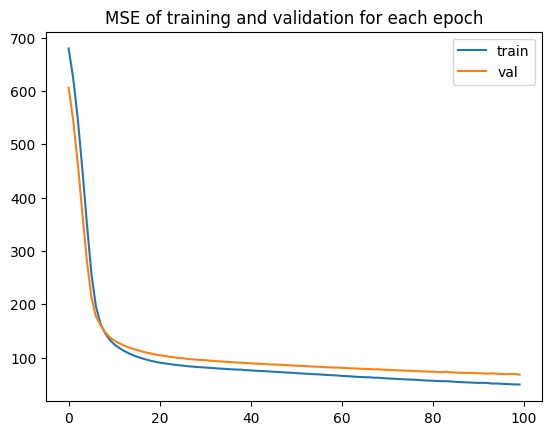

In [22]:
plt.plot(history.history['mse'], label='train');
plt.plot(history.history['val_mse'], label='val');
plt.title('MSE of training and validation for each epoch');
plt.legend();

### Test

In [23]:
predictions = model.predict(X_test_scaled)

95/95 [==============================] - 0s 2ms/step


In [24]:
def add_predictions(df,predictions):
    df["prediction"] = predictions
    return df

In [25]:
predictions

array([[0.      ],
       [0.      ],
       [0.      ],
       ...,
       [0.      ],
       [0.      ],
       [2.792381]], dtype=float32)

In [26]:
y_pred = predictions.reshape(-1)

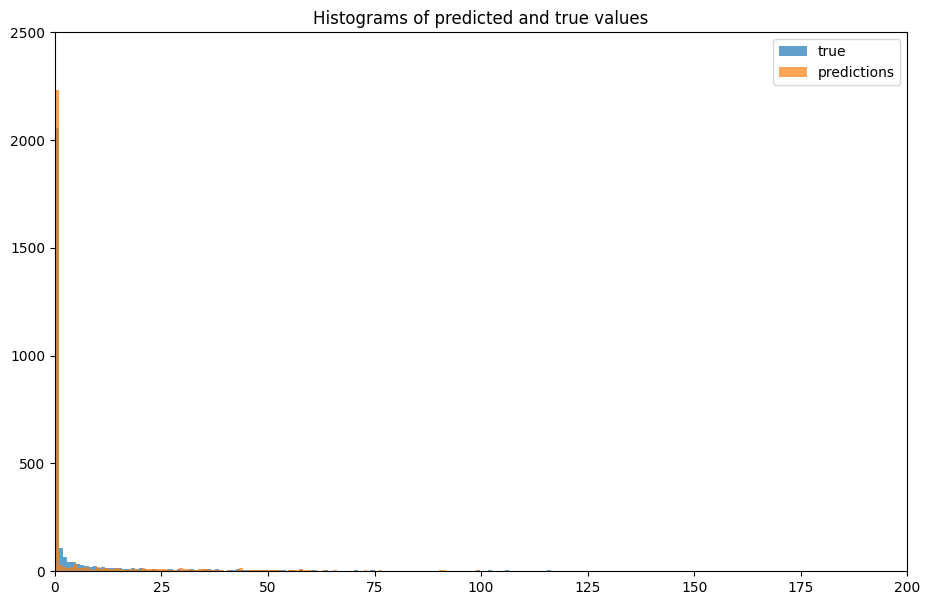

In [29]:
plt.figure(figsize=(11,7))
_ = plt.hist(y_test, bins=200, alpha=0.7, label="true")  # arguments are passed to np.histogram
_ = plt.hist(y_pred, bins=200, alpha=0.7, label="predictions")  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()
plt.title("Histograms of predicted and true values")
plt.xlim([0, 200])
plt.ylim([0, 2500])
plt.legend()
plt.show()

In [33]:
y_pred.max()

176.6696

In [35]:
mse = mean_squared_error(y_pred, y_test)
mse

67.80012719410038

In [36]:
y_test.mean()

9.855808010592519

In [37]:
y_pred.mean()

9.485956

## Adjusting the Learning Rate

https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/08-deep-learning/notebook.ipynb

In [39]:
def get_model(n_inputs, n_outputs, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [40]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_val_scaled, y_val),
        verbose=0
    )
    scores[lr] = history.history

    print()
    print()

0.0001


0.001


0.01


0.1




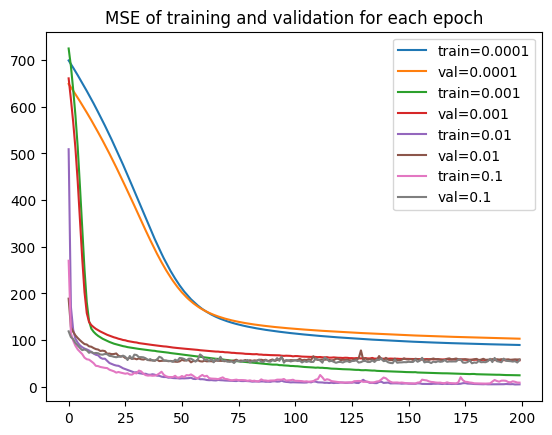

In [41]:
for lr, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % lr));
    plt.plot(hist['val_mse'], label=('val=%s' % lr));
plt.title('MSE of training and validation for each epoch');
plt.legend();

#### Summary
- Learning rates of 0.0001 and 0.001 make the model learn too slow.
- Learning rates of 0.01 and 0.1 give similar results however with 0.1 values are not smooth.
- The best value of **learning rate** for our model: **0.01**.

### Tuning the size of an inner layer

In [42]:
def get_model(n_inputs, n_outputs, learning_rate=0.01, size=32):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(size, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=['mse'])
    return model

In [43]:
scores = {}
lr = 0.01

for s in [16, 32, 64, 128, 256]:
    print(s)

    model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr, size=s)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=1024,
        epochs=200,
        validation_data=(X_val_scaled, y_val),
        verbose=0
    )
    scores[s] = history.history

    print()
    print()

16


32


64


128


256




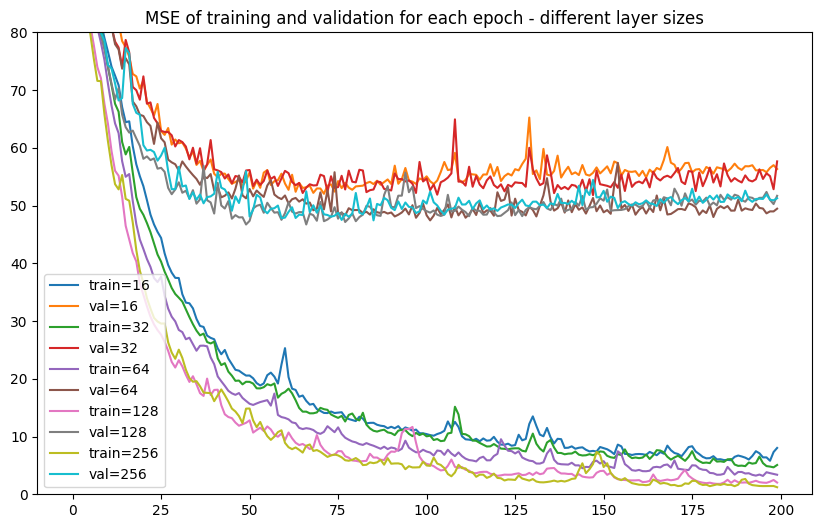

In [48]:
plt.figure(figsize=(10,6));
for s, hist in scores.items():
    plt.plot(hist['mse'], label=('train=%s' % s));
    plt.plot(hist['val_mse'], label=('val=%s' % s));
plt.title('MSE of training and validation for each epoch - different layer sizes');
plt.ylim([0,80]);
plt.legend();

#### Summary
- The larger the layer the lower the MSE for training and validation sets but only till size 128.
- For val-MSE size 256 give most of the time worse results than size 128. 
- We choose the **size-128** for the inner layer.

### Checkpointing

In [56]:
# 'xception_v1_{epoch:02d}_{val_mse:.3f}.h5'
# UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

chechpoint = keras.callbacks.ModelCheckpoint(
    'model_solar_energy_production.keras',
    # 'model_ckpt_v1_{epoch:02d}_{val_mse:.3f}.keras',
    save_best_only=True,
    monitor='val_mse',
    mode='min'
)

lr = 0.01
s = 128
model = get_model(X_train_scaled.shape[1], 1, learning_rate=lr, size=s)

history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=70,
    validation_data=(X_val_scaled, y_val),
    # verbose=0,
    callbacks=[chechpoint]
)

Epoch 1/70
9/9 [==============================] - 1s 23ms/step - loss: 576.9244 - mse: 576.9244 - val_loss: 216.6963 - val_mse: 216.6963
Epoch 2/70
9/9 [==============================] - 0s 10ms/step - loss: 183.7250 - mse: 183.7250 - val_loss: 153.1109 - val_mse: 153.1109
Epoch 3/70
9/9 [==============================] - 0s 9ms/step - loss: 122.7818 - mse: 122.7818 - val_loss: 128.1032 - val_mse: 128.1032
Epoch 4/70
9/9 [==============================] - 0s 10ms/step - loss: 100.0959 - mse: 100.0959 - val_loss: 107.4267 - val_mse: 107.4267
Epoch 5/70
9/9 [==============================] - 0s 10ms/step - loss: 91.9632 - mse: 91.9632 - val_loss: 98.7055 - val_mse: 98.7055
Epoch 6/70
9/9 [==============================] - 0s 7ms/step - loss: 86.4891 - mse: 86.4891 - val_loss: 99.4432 - val_mse: 99.4432
Epoch 7/70
9/9 [==============================] - 0s 9ms/step - loss: 82.7862 - mse: 82.7862 - val_loss: 89.9744 - val_mse: 89.9744
Epoch 8/70
9/9 [==============================] - 0s 9ms

In [57]:
model_test = keras.models.load_model('model_solar_energy_production.keras')

In [58]:
model.evaluate(x=X_test_scaled,y=y_test)

95/95 [==============================] - 0s 1ms/step - loss: 50.1756 - mse: 50.1756


[50.175621032714844, 50.175621032714844]